In [1]:
%pylab inline
import ThonkTools as TT
from uncertainties import unumpy as unp
from uncertainties import ufloat
from scipy import interpolate
from scipy.optimize import curve_fit
import pandas as pd
import peakutils
from peakutils.plot import plot as pplot

Populating the interactive namespace from numpy and matplotlib


In [2]:
def csvReader(x):
    """
        csvReader takes a csv file and creats a list with lists of the colloms.
        It also turns strings into numbers if possible.
    """
    import csv
    with open(x, 'r') as csvFile:
        reader = csv.reader(csvFile)
        l = None
        for row in reader:
            if l == None:
                l = [[] for i in range(len(row))]
                for i in range(len(l)):
                    try:
                        try:
                            l[i].append(float(row[i]))
                        except:
                            l[i].append(row[i])
                    except:
                        None
            else:
                for i in range(len(l)):
                    try:
                        try:
                            l[i].append(float(row[i]))
                        except:
                            l[i].append(row[i])
                    except:
                        None
    return l    
    csvFile.close()

In [3]:
def read(filename):
    from numpy import array as array
    df = pd.read_csv(filename,skiprows=1,names=["Width in A","Voltage in V"],sep="\t")
    data = [[],[]]

    for i in range(2):
        for k in range(len(df.iloc[0:,i])):
            data[i].append((df.iloc[k,i].replace(",",".")))
    for i in range(len(data)):
        for k in range(len(data[i])):
            try:
                #print(i,k, data[i][k])
                data[i][k] = float(data[i][k])
            except ValueError:
                data[i][k] = 0
    for i in range(len(data)):
        data[i]= array(data[i])
    return data
[pos, inte] = range(2)
data = read("abs30.csv")

In [302]:
def fit_pm(x, y, func=lambda x: x, p0=None, sigma=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0, sigma=sigma)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2
    
def linfit_pm(x, y, p0=None, sigma=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0, sigma=sigma)

In [303]:
def fit(x, y, func=lambda x: x, p0=None, r=None, d=None, sigma=None):
    """
        fit takes data points, calculates the curve fit, and gives back
        the values with which the curve can be plotted
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: the function type the curve_fit will be applied to.
        r: determines the size of steps in which the x-achse intervall is split.
        d: tuple which determines the start and end point of the x-achse intervall on which the
            will be drawn. If not given the curve will be drawn between the largest and the smalest
            given x-value.
        Returns:
        -----------
        xnew: x-value with which the fitted curve can be plotted.
        ynew: y-value with which the fitted curve can be plotted.
    """
    import numpy as np
    from scipy.optimize import curve_fit
    popt, pvoc = curve_fit(func, x, y, p0=p0, sigma=sigma)
    params = popt.copy()
    if d == None:
        if r == None:
            xnew = np.arange(min(x), max(x), np.abs((max(x) - min(x)) / 100))
        else:
            xnew = np.arange(min(x), max(x), r)
    else:
        if r == None:
            xnew = np.arange(min(d), max(d), np.abs((max(x) - min(x)) / 100))
        else:
            xnew = np.arange(min(d), max(d), r)
    ynew = func(xnew, *params)
    return xnew, ynew

def linfit(x, y, p0=None, r=None, d=None, sigma=None):
    return fit(x, y, func=lambda x, a, b,: a * x + b, r=r, d=d, p0=p0, sigma=sigma)

In [311]:
def error(arr):
    arr_error = []
    arr_value = []
    for i in range(len(arr)):
        arr_error.append(arr[i].std_dev)
        arr_value.append(arr[i].nominal_value)
    return arr_error, arr_value

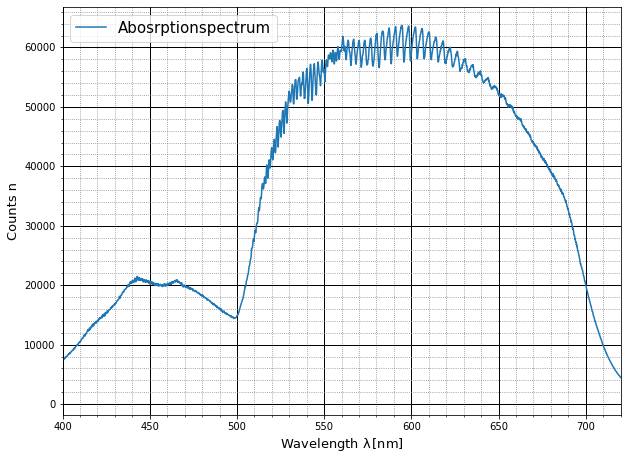

In [312]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

plt.plot(data[0],np.array(data[1]),label='Abosrptionspectrum')

indexes = peakutils.indexes(-1*np.array(data[1][610:1000]), thres=0.22, min_dist=2)
#print(indexes)
y = -1*np.array(data[1][610:1000])
x = data[0][610:1000]
#print(x[indexes], y[indexes])
#pyplot.figure(figsize=(10,6))
#pplot(x, -y, indexes)
#pyplot.title('First estimate')
x = x[indexes]
y = -y[indexes]

#plt.plot(x,y,'x',label='Transition Minima')
#plt.plot(data[0], np.array(data[1]))
#plt.plot(data[0][610:1000],np.array(data[1][610:1000]),label='Abosrptionspectrum')

###   Label / Title

plt.ylabel(r'Counts n', fontsize=13)
plt.xlabel(r'Wavelength $\mathrm{\lambda}\,$[nm]', fontsize=13)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

axes.set_xlim([400,720])
#axes.set_ylim([20000,60000])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend(fontsize=15)
plt.savefig('Eichung.png')
plt.show()

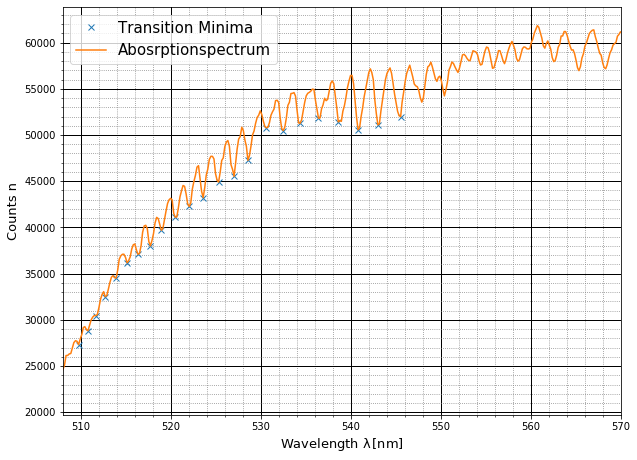

In [305]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

#plt.plot(data[0],-1*np.array(data[1]))

indexes = peakutils.indexes(-1*np.array(data[1][610:1000]), thres=0.22, min_dist=2)
#print(indexes)
y = -1*np.array(data[1][610:1000])
x = data[0][610:1000]
#print(x[indexes], y[indexes])
#pyplot.figure(figsize=(10,6))
#pplot(x, -y, indexes)
#pyplot.title('First estimate')
x = x[indexes]
y = -y[indexes]

plt.plot(x,y,'x',label='Transition Minima')
#plt.plot(data[0], np.array(data[1]))
plt.plot(data[0][610:1000],np.array(data[1][610:1000]),label='Abosrptionspectrum')

###   Label / Title

plt.ylabel(r'Counts n', fontsize=13)
plt.xlabel(r'Wavelength $\mathrm{\lambda}\,$[nm]', fontsize=13)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

axes.set_xlim([508,570])
#axes.set_ylim([20000,60000])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend(fontsize=15)
plt.savefig('Eichung.png')
plt.show()

In [306]:
G = 1/(unp.uarray(x,0.1) * 10**-7)
l = []
n = []
o = arange(25.5,47.5,1)
for i in range(len(G)-1):
    l.append(G[i] - G[i+1])
for i in range((len(o))):
    n.append(o[-(i+1)])
l = np.array(l)

In [307]:
print(np.array(l),len(l))
print()
print(n,len(n))

[39.93922882273182+/-5.431041700213166
 33.285985511072795+/-5.4107618926248335
 39.64191615703021+/-5.39061217290195
 46.29852464119904+/-5.366915680399785
 45.702425141775166+/-5.3415989163932664
 45.48823374654603+/-5.316564559497969
 51.992667612481455+/-5.289875328872847
 45.0330516547001+/-5.2633635893829736
 57.381082326977776+/-5.235472683515784
 57.040352611595154+/-5.204384094445097
 56.70264879941533+/-5.173571595662439
 62.16762018247755+/-5.141475218115037
 62.12421783008904+/-5.108014545804418
 55.27979409749969+/-5.076500004406557
 73.08888466117423+/-5.042187349065253
 66.53318003867025+/-5.004962897952235
 65.71486848920176+/-4.9698395887837945
 71.16640207812088+/-4.933625105400206
 76.14392215247426+/-4.894798694314451
 75.52443090312227+/-4.854974959812713
 74.91246910434347+/-4.8156352635322195
 85.40241182689715+/-4.773907456994812] 22

[46.5, 45.5, 44.5, 43.5, 42.5, 41.5, 40.5, 39.5, 38.5, 37.5, 36.5, 35.5, 34.5, 33.5, 32.5, 31.5, 30.5, 29.5, 28.5, 27.5, 26.5, 25

(array([-2.0890926350709043+/-0.1336477304980328,
       133.68871748702634+/-4.820300763106733], dtype=object), 0.9241918628782224)


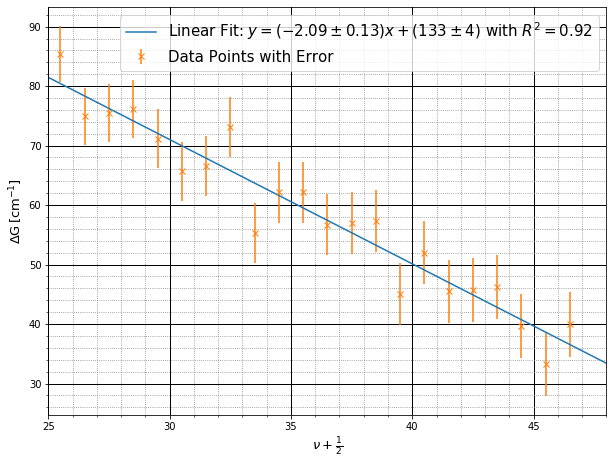

In [340]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

#plt.plot(data[0],-1*np.array(data[1]))

#plt.plot(n,error(l)[1],'x')

xnew,ynew = linfit(n, error(l)[1], sigma=error(l)[0],d=(25,50))
k = linfit_pm(n, error(l)[1], sigma=error(l)[0])
print(k)
plt.plot(xnew,ynew,label=r'Linear Fit: $y=(-2.09 \pm 0.13)x+(133\pm 4)$ with $R^2=0.92$')
plt.errorbar(n,error(l)[1],error(l)[0],fmt='x',label='Data Points with Error')

#plt.plot(n[0:16]+n[19:],l[0:16]+l[19:],'x')
#plt.plot(n[16:19],l[16:19],'x')

###   Label / Title

plt.ylabel(r'$\Delta \mathrm{G}\,[\mathrm{cm}^{-1}]$', fontsize=13)
plt.xlabel(r'$\nu+\frac{1}{2}$', fontsize=13)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

axes.set_xlim([25,48])
#axes.set_ylim([20000,60000])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend(fontsize=15)
#plt.savefig('Eichung.png')
plt.show()

In [365]:
omega_x = -k[0][0]/2
omega = k[0][1] + omega_x
D_e = omega**2/(4*omega_x)
v_diss = -k[0][1]/k[0][0]
print(omega,omega_x,D_e,v_diss)

135+/-5 1.04+/-0.07 (4.3+/-0.4)e+03 64+/-5


In [506]:
p = np.arange(0.5,64.5,1)
d_y = k[0][1] + p * k[0][0]
d_y_e = error(d_y)
print(sqrt(sum(np.array(d_y_e[1][:2])**2)))
sum(d_y[:2])

186.1158367156588


263.1992497039108+/-9.64430633330871

In [600]:
sum(d_y)

4277.616202544475+/-412.41878332963586

In [601]:
s = np.array(d_y_e[0])**2
sqrt(sum(s))

55.20638052086619

In [602]:
sum(unp.uarray(d_y_e[1],d_y_e[0]))

4277.616202544475+/-55.20638052086619

In [550]:
print(d_y[:2])

[132.64417116949087+/-4.820763930724484
 130.55507853441998+/-4.824467670894761]


In [539]:
len(d_y_e)

64

In [593]:
k = unp.uarray(d_y_e[1][:2],d_y_e[0][:2])
print(k)
type(k)

[132.64417116949087+/-4.820763930724484
 130.55507853441998+/-4.824467670894761]


numpy.ndarray

In [594]:
d = d_y[:2]
print(d)
type(d)

[132.64417116949087+/-4.820763930724484
 130.55507853441998+/-4.824467670894761]


numpy.ndarray

In [595]:
print(sum(d),sum(k))

263+/-10 263+/-7
